<a href="https://colab.research.google.com/github/Namtk214/Sentiment_Analysis/blob/main/PRJ_module_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!gdown 1nxR07ebVNc5bSgfTQjeUcAoyoaNuuH6s

Downloading...
From: https://drive.google.com/uc?id=1nxR07ebVNc5bSgfTQjeUcAoyoaNuuH6s
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 112MB/s]


In [22]:
import pandas as pd
df = pd.read_csv('/content/IMDB-Dataset.csv')
df.drop_duplicates()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Data cleaning

In [23]:
pip install contractions

In [24]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
#Expanding contractions (Example: I'm -> I am....)
def expand_contractions(text):
    return contractions.fix(text)

# Functions to clean data
def preprocess_text(text):
  wl = WordNetLemmatizer()


  soup = BeautifulSoup(text, 'html.parser') # Removing HTML tags
  text = soup.get_text()

  text = expand_contractions(text) # Expanding contractions

  emoji_clean = re.compile("["
 u"\U0001F600-\U0001F64F " # emoticons
 u"\U0001F300-\U0001F5FF " # symbols & pictographs
 u"\U0001F680-\U0001F6FF " # transport & map symbols
 u"\U0001F1E0-\U0001F1FF " # flags (iOS)
 u"\U00002702-\U000027B0 "
 u"\U000024C2-\U0001F251 "
 "]+", flags =re.UNICODE )

  text = emoji_clean.sub(r'', text)
  text = re.sub(r'\.(?=\S)', '.', text) #Add space after full stop
  text = re.sub(r'http\S+', '', text) #Remove urls
  text = "".join([
      word.lower() for word in text if word not in string.punctuation
  ]) #Remove punctuations and make textlowercase
  stop = stopwords.words('english') # Defining the stop variable
  text = " ".join([
      wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
  ]) #Lemmatize
  text = " ".join([
      wl.lemmatize(word) for word in text.split()
  ])
  return text

In [26]:
df['review'] = df['review'].apply(preprocess_text)
df.head()

<ipython-input-25-fae88e0a8ebb>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # Removing HTML tags


,review,sentiment
0,,positive
1,awonderfullittleproductionthefilmingtechniquei...,positive
2,,positive
3,,negative
4,pettermatteisloveinthetimeofmoneyisavisuallyst...,positive


Data mining

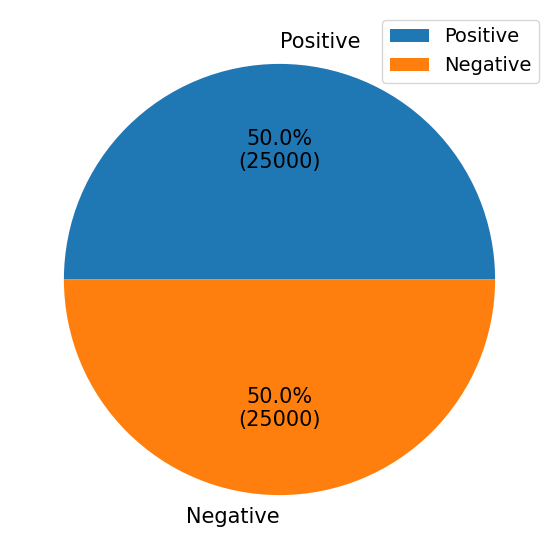

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Create autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['Positive', 'Negative']

fig, ax = plt.subplots(figsize =(11, 7))
plt.pie(data, labels = labels, autopct = lambda pct: func(pct, data),
        textprops={'fontsize': 15})

labels = [r'Positive', r'Negative']
plt.legend(labels, loc ="best", prop={'size': 14})
plt.show()


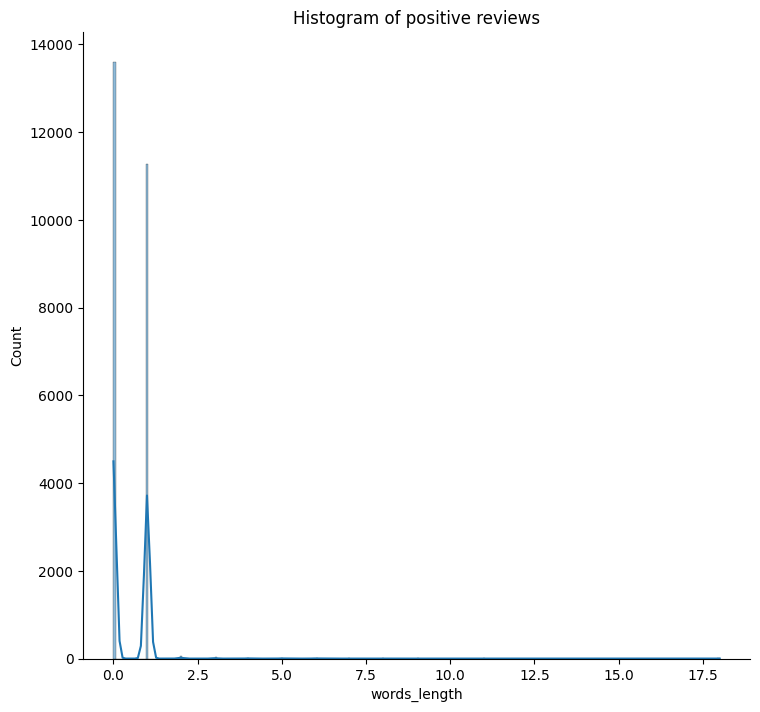

In [28]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words_length'] = words_len

hist_positive = sns.displot(
    df_temp[df_temp['sentiment'] == 'positive'],
    x='words_length', hue="sentiment", kde=True, height=7, aspect=1.1, legend=False).set(title='Histogram of positive reviews')
plt.show(hist_positive)


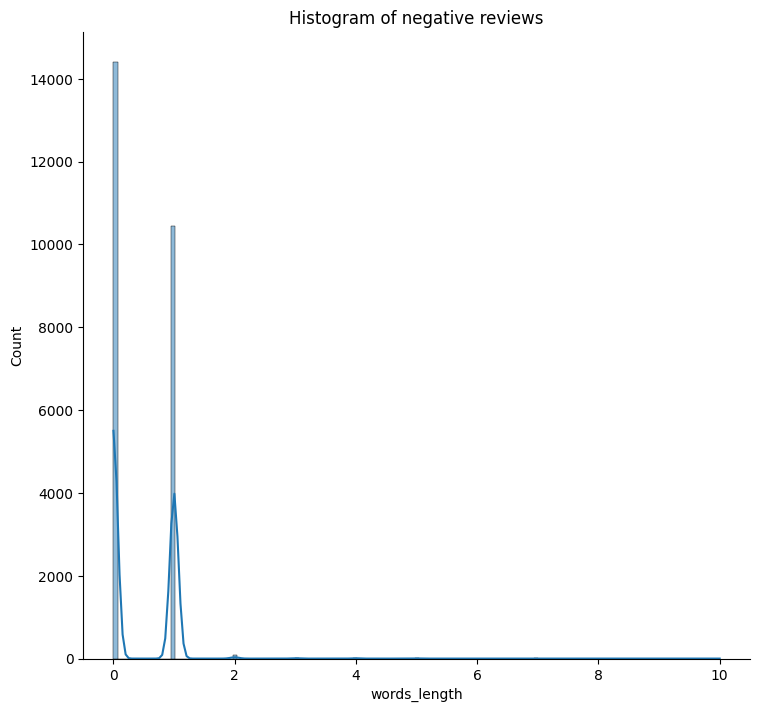

In [29]:
hist_negative = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x='words_length', hue="sentiment", kde=True, height=7, aspect=1.1, legend=False).set(title='Histogram of negative reviews')
plt.show(hist_negative)

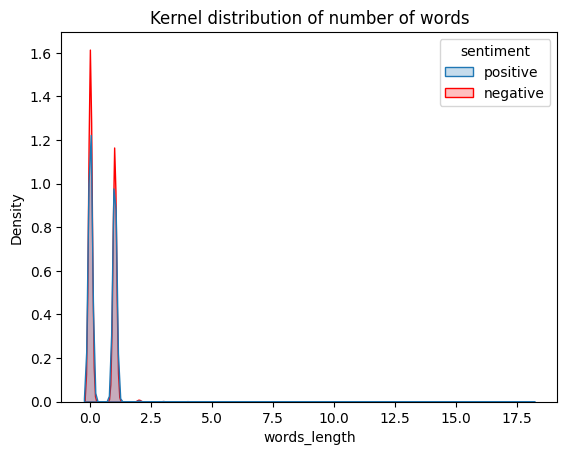

In [30]:
kernel_distribution_number_words_plot = sns.kdeplot(
    data = df_temp, x="words_length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']).set(title='Kernel distribution of number of words') # Changed 'word_length' to 'words_length'
plt.show(kernel_distribution_number_words_plot)

Spliting the dataset

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(df['sentiment'])
x_data = df['review']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

Vectorizing

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

Train model

In [33]:
pip install xgboost

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Decision Tree Classifier

In [35]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=10,
    random_state=42
)
dt_classifier.fit(x_train_tfidf, y_train)
y_predict = dt_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)
#

0.4971

Random Forest Classifier

In [37]:
rf_classifier = RandomForestClassifier(
    # n_estimators=100,
    # criterion='entropy',
    # random_state=42
    )
rf_classifier.fit(x_train_tfidf, y_train)
y_predict = rf_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)

0.4971

Adaboost Classifier

In [38]:
ada_classifier = AdaBoostClassifier()
ada_classifier.fit(x_train_tfidf, y_train)
y_predict = ada_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)

0.4962

Gradient Boost

In [39]:
gradient_classifier = GradientBoostingClassifier()
gradient_classifier.fit(x_train_tfidf, y_train)
y_predict = gradient_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)

0.4962

XGBoost

In [40]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train_tfidf, y_train)
y_predict = xgb_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)

0.4961

Support Vector Machine

In [43]:
svm_classifier = SVC()
svm_classifier.fit(x_train_tfidf, y_train)
y_predict = svm_classifier.predict(x_test_tfidf)
accuracy_score(y_predict, y_test)

0.4971